### Load Data, drop empty Txt and Settings
----

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import svm
from sklearn.svm import SVC

In [2]:
## SETTINGS

# active models
SET_NN_active = False

SET_track_scores = True

SET_SVM_active = True

SET_datapath = "data_pp.json"
SET_name_outputfile = "performance_final.csv"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,u created request scholarlyarticles awaiting c...,1,6
1,looking lgbt profession category point get beh...,1,17
2,new york city regulation regarding apparently ...,0,12
3,thank speedy rollback would believe first time...,1,16
4,want talk stuff perfectly willing refer commen...,0,53


### Word Embedding

----

#### TFidf Vectorizer

In [3]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500)
X = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
y = df['toxic'].values

### Split Data for Models
----

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (240368, 500)
X_test shape: (60092, 500)
y_train shape: (240368,)
y_test shape: (60092,)


### Train Models and get Scores

----

#### Try... Neural Network

In [6]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [7]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report["1"]["recall"]
        precision = report["1"]["precision"]
        f1_score = report["1"]["f1-score"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall', 'F1-Score']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'TFidf', 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

#### Naive Bayes:

--------------------Training Performance---------------------
0.70614224855222
              precision    recall  f1-score   support

           0       0.70      0.98      0.81    156329
           1       0.82      0.20      0.33     84039

    accuracy                           0.71    240368
   macro avg       0.76      0.59      0.57    240368
weighted avg       0.74      0.71      0.64    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7044698129534713
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     39082
           1       0.82      0.20      0.32     21010

    accuracy                           0.70     60092
   macro avg       0.76      0.59      0.57     60092
weighted avg       0.74      0.70      0.64     60092



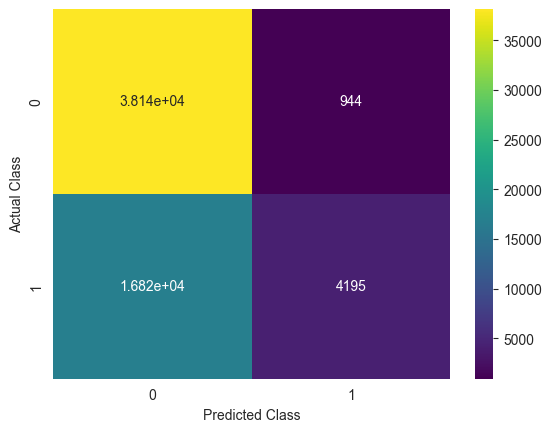

In [8]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Support Vector Machine

[LibSVM]

D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


--------------------Training Performance---------------------
0.5716609532050856
              precision    recall  f1-score   support

           0       0.70      0.60      0.64    156329
           1       0.41      0.53      0.46     84039

    accuracy                           0.57    240368
   macro avg       0.56      0.56      0.55    240368
weighted avg       0.60      0.57      0.58    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.57119084071091
              precision    recall  f1-score   support

           0       0.70      0.60      0.64     39082
           1       0.41      0.53      0.46     21010

    accuracy                           0.57     60092
   macro avg       0.56      0.56      0.55     60092
weighted avg       0.60      0.57      0.58     60092



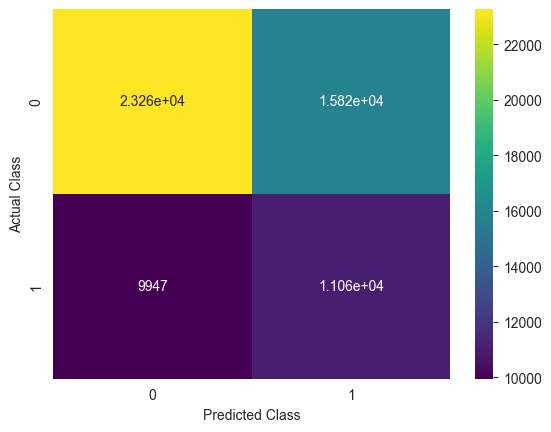

In [9]:
if SET_SVM_active:
    modelSVM = svm.SVC(kernel = 'linear', max_iter = 10000, verbose=True)
    model_train(modelSVM, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7078479664514411
              precision    recall  f1-score   support

           0       0.70      0.97      0.81    156329
           1       0.81      0.22      0.34     84039

    accuracy                           0.71    240368
   macro avg       0.75      0.59      0.58    240368
weighted avg       0.74      0.71      0.65    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7050356120615057
              precision    recall  f1-score   support

           0       0.70      0.97      0.81     39082
           1       0.79      0.21      0.33     21010

    accuracy                           0.71     60092
   macro avg       0.75      0.59      0.57     60092
weighted avg       0.73      0.71      0.64     60092



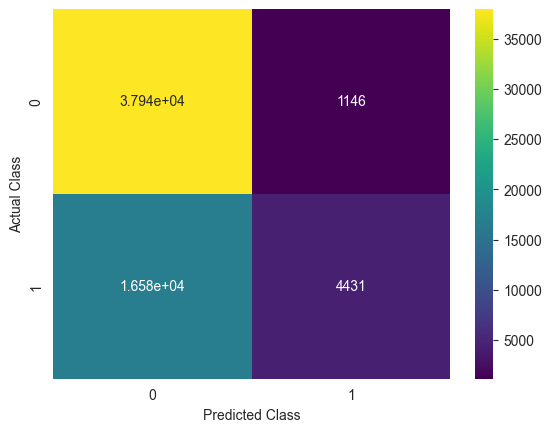

In [10]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.6916186846834853
              precision    recall  f1-score   support

           0       0.68      1.00      0.81    156329
           1       0.95      0.12      0.22     84039

    accuracy                           0.69    240368
   macro avg       0.81      0.56      0.51    240368
weighted avg       0.77      0.69      0.60    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6888936963322905
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     39082
           1       0.92      0.12      0.21     21010

    accuracy                           0.69     60092
   macro avg       0.80      0.56      0.51     60092
weighted avg       0.76      0.69      0.60     60092



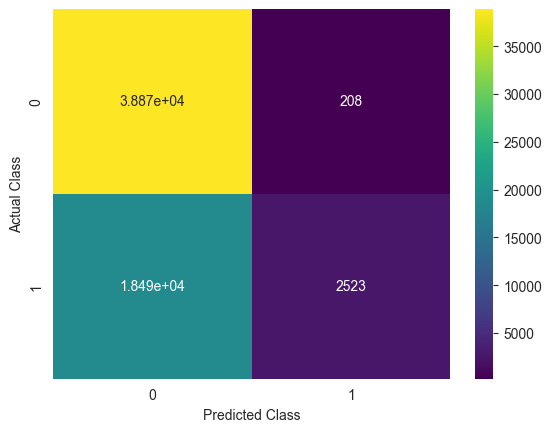

In [11]:
model = RandomForestClassifier(n_estimators=100,max_depth=10,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [12]:
print("finished")

finished
